In [1]:
import pandas as pd
import numpy as np

# Đọc dữ liệu từ file CSV
data = pd.read_csv("./data_rfm.csv")

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data = data.dropna(subset=['CustomerID'])
last_date = data['InvoiceDate'].max()
print(last_date)

rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (last_date - x.max()).days,
    'InvoiceNo': 'count',
    'UnitPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()

2011-12-09 12:50:00


,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,2,2.08
1,12347.0,1,182,481.21
2,12348.0,74,31,178.71
3,12349.0,18,73,605.10
4,12350.0,309,17,65.30


In [2]:
from sklearn.preprocessing import StandardScaler

customer_ids = rfm['CustomerID']
rfm_data = rfm.drop('CustomerID', axis=1)

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

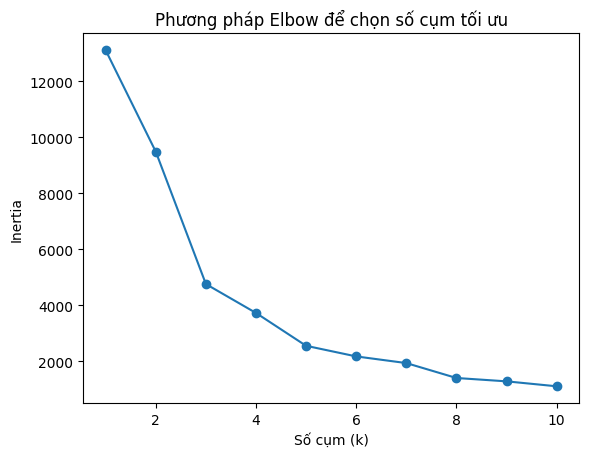

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Vẽ biểu đồ inertia
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Số cụm (k)')
plt.ylabel('Inertia')
plt.title('Phương pháp Elbow để chọn số cụm tối ưu')
plt.show()

In [4]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(rfm_scaled)

KMeans(n_clusters=5, random_state=42)

In [5]:
rfm['Cluster'] = kmeans.labels_
rfm

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,325,2,2.08,1
1,12347.0,1,182,481.21,0
2,12348.0,74,31,178.71,0
3,12349.0,18,73,605.10,0
4,12350.0,309,17,65.30,1
...,...,...,...,...,...
4367,18280.0,277,10,47.65,1
4368,18281.0,180,7,39.36,1
4369,18282.0,7,13,62.68,0
4370,18283.0,3,756,1220.93,4


In [6]:
cluster_centers_scaled = kmeans.cluster_centers_
cluster_centers = scaler.inverse_transform(cluster_centers_scaled)
for i, center in enumerate(cluster_centers):
    center = center.astype(np.int32)
    print(f"Tâm cụm của cụm {i}: {center}")

Tâm cụm của cụm 0: [ 42  71 222]
Tâm cụm của cụm 1: [249  27  99]
Tâm cụm của cụm 2: [   90   169 29832]
Tâm cụm của cụm 3: [    1  5913 26971]
Tâm cụm của cụm 4: [  14  503 1605]


In [7]:
cluster_counts = rfm['Cluster'].value_counts()

# Hiển thị kết quả
print("Số lượng khách hàng thuộc mỗi cụm:")
print(cluster_counts)

Số lượng khách hàng thuộc mỗi cụm:
Cluster
0    3032
1    1065
4     268
3       4
2       3
Name: count, dtype: int64


In [8]:
rfm.to_csv("rfm_with_labels.csv", index=False)

In [9]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

rfm_labeled = pd.read_csv("rfm_with_labels.csv")

new_customer_rfm = [10, 100, 1000]

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_labeled[['Recency', 'Frequency', 'Monetary']])
new_customer_rfm_scaled = scaler.transform([new_customer_rfm])

X_train = rfm_scaled
y_train = rfm_labeled['Cluster']
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

predicted_cluster = knn_model.predict(new_customer_rfm_scaled)
print("Khách hàng mới được dự đoán thuộc cụm:", predicted_cluster)

Khách hàng mới được dự đoán thuộc cụm: [0]


c:\Users\ThanhNC\Desktop\Nestech\Nestech_PK36\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
